In [1]:
import numpy as np
import pandas as pd
import torch as t
import matplotlib.pyplot as plt
import seaborn as sb

from scipy.interpolate import interp1d
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr


import importlib

import random
random.seed(715)

自定义工具

In [55]:
# Evaluation Function Defination
from utils.evaluate import evaluate
from utils.data_maker import SampleSet


# Data_maker utils
import utils.data_maker as maker
## data transform methods
from utils.data_maker import normalized_trans, normalized_trans2


# Simulation methods
## general framework
from utils.simulator import Network
from utils.simulator import LstmNetwork

## simulator test
from utils.simulator import lr_test, nn_test


# Data Analyzing methods
from utils.eda import quintile

## Load original data

In [8]:
#定义常量
FTR_COLS = ['InRateA', 'InTemp', 'HeatTemp', 'InSpeed']
VAL_COLS = ['OutRateC', 'OutRateD', 'OutRateE', 'OutRateA', 'OutRateB']
MID_COLS = ['OutTemp', 'OutSpeed']
PRED_COLS = MID_COLS + VAL_COLS

NEW_FTR_VOLS = ['InMassA', 'InMassB', 'Valve', 'Purity', 
                'InTemp', 'HeatTemp', 'InSpeed']
NEW_VAL_COLS = ['OutMassA', 'OutMassB', 'OutMassB', 'OutMassB', 'OutMassB']
NEW_MID_COLS = ['OutTemp', 'OutSpeed_n']

In [9]:
dintemp = pd.read_csv('data/test_data1.csv')
dheattemp = pd.read_csv('data/test_data2.csv')
dinspeed = pd.read_csv('data/test_data3.csv')
dinrate = pd.read_csv('data/test_data4.csv')
dold = pd.concat([dintemp, dheattemp, dinspeed, dinrate]).reset_index(drop=True)\
         .drop(['InPress', 'Thres', 'OutPress'], 1)


d60 = pd.read_csv('data/mock_data_3.csv')
d240 = pd.read_csv('data/mock_data_2.csv')
d700 = pd.read_csv('data/mock_data_1.csv')
dnew = pd.concat([d700, d240, d60]).reset_index(drop=True)\
         .drop(['InPress', 'Thres', 'OutPress'], 1)


In [10]:
dm= dnew.copy(deep=True)


## 输入特征处理

### 新增特征： 来源和纯度
设置3个来源的纯度分布

设置来源纯度的候选集

In [13]:

from utils.data_maker import SampleSet

set_a = SampleSet(0.94, 0.028, 5000, minv=0.85, maxv=0.9995)
set_b = SampleSet(0.97, 0.024, 5000, minv=0.90, maxv=0.9995)
set_c = SampleSet(0.99, 0.012, 5000, minv=0.95, maxv=0.9995)

sample_sets = [set_a, set_b, set_c]

src_a = set_a.get_samples(500)
src_b = set_b.get_samples(500)
src_c = set_c.get_samples(500)

生成每个来源的纯度

In [15]:
sample_sets = [set_a, set_b, set_c]

def gen_densy(id_num_pairs):
    ids = np.array(sum([[i]* n for i, n in id_num_pairs], []))
    vals = np.array(sum([list(sample_sets[i].get_samples(n)) \
                         for i, n in id_num_pairs], 
                        []))
    return ids, vals

In [18]:
ids, vals = gen_densy([((i+1) % 3, 100) for i in range(10)])

In [19]:
dm["SrcId"] = ids
dm["Purity"] = vals

观察来源分布数据

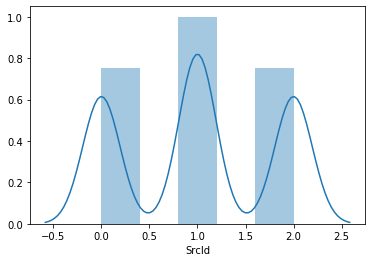

In [20]:
sb.distplot(dm.SrcId)

In [21]:
dm[['SrcId', 'Purity', 'OutRateC']].corr()

,SrcId,Purity,OutRateC
SrcId,1.000000,0.673086,-0.133149
Purity,0.673086,1.000000,-0.066455
OutRateC,-0.133149,-0.066455,1.000000


[0.86722425 0.94516142 0.96841142 0.98487549 0.99949444]
[0.86722425 0.92057943 0.93985342 0.95783646 0.99934239]
[0.90071664 0.95034081 0.9644808  0.97871641 0.99864827]
[0.95550094 0.98015108 0.98693637 0.99339308 0.99949444]


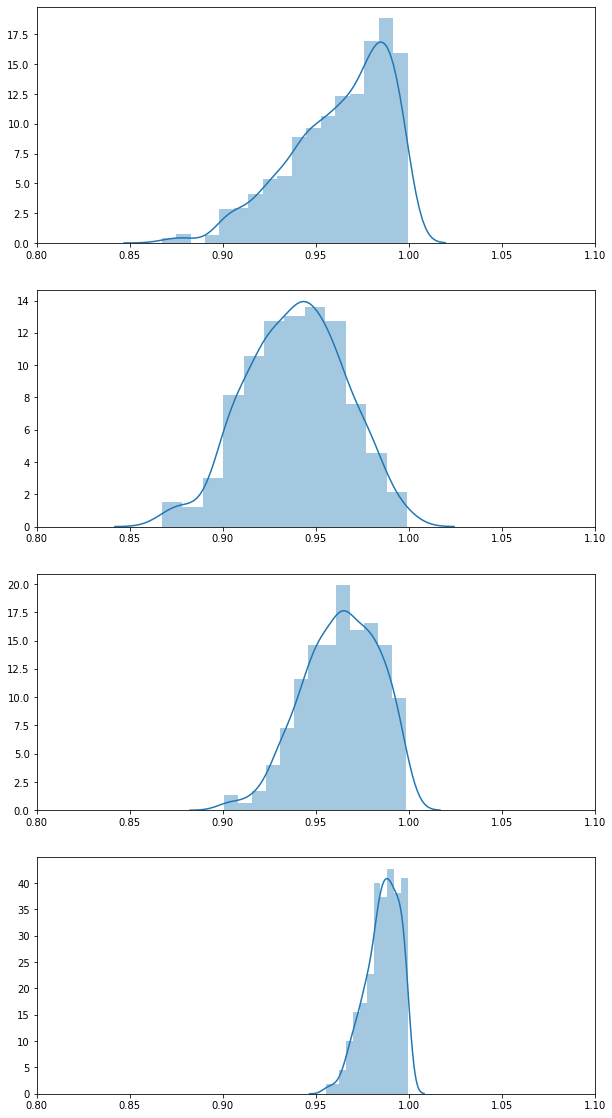

In [22]:
a = ids
b = vals

print(np.percentile(b, [0, 25, 50, 75, 100]))
plt.subplots(figsize=(10, 20))
plt.subplot(411)
plt.xlim(0.8, 1.1)
sb.distplot(b)
plt.subplot(412)
plt.xlim(0.8, 1.1)
print(np.percentile(b[a==0], [0, 25, 50, 75, 100]))
sb.distplot(b[a==0])
plt.subplot(413)
plt.xlim(0.8, 1.1)
print(np.percentile(b[a==1], [0, 25, 50, 75, 100]))
sb.distplot(b[a==1])
plt.subplot(414)
plt.xlim(0.8, 1.1)
print(np.percentile(b[a==2], [0, 25, 50, 75, 100]))
sb.distplot(b[a==2])

### 新增特征：质量、阀门开度特征

In [23]:
dm['InMassA'] = 5.81 * dm.InSpeed / dm.Purity * dm.InRateA

In [24]:
dm['InMassB'] = 5.81 * dm.InSpeed / dm.Purity * dm.InRateB

In [25]:
dm['Valve'] = (12.78 * dm.InSpeed) ** 0.5 + np.random.randn(1000) * 0.0003

## 修正输出量

C物质输出非线性化

In [26]:
xx = maker.normalized_trans(dm.OutRateC.values, 
                             maker.nonlinearize,
                             kl = [1.3, -0.5, 0.2, -0.05])

增加C物质输出受输入的非线性影响

In [27]:
xx = maker.normalized_transx(xx, maker.trans,
                        dm.InTemp.values, dm.InRateA.values, dm.HeatTemp.values,
                        ul = [1.02, 1.01, 1.01],
                        kl = [0.8, 0.8, 0.6])

观察C物质输出与原始数据的差异

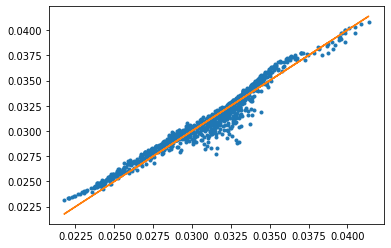

In [28]:
plt.plot(dm.OutRateC.values, xx, '.')
plt.plot(dm.OutRateC.values, dm.OutRateC.values)

获得神经网络模型，并观察效果

mse: 5.857731679545995e-08 
mape 0.0064098568052549515 
r2: 0.9956045532947547 
cor: 0.9977999802713665 
pre: 0.999918168254514


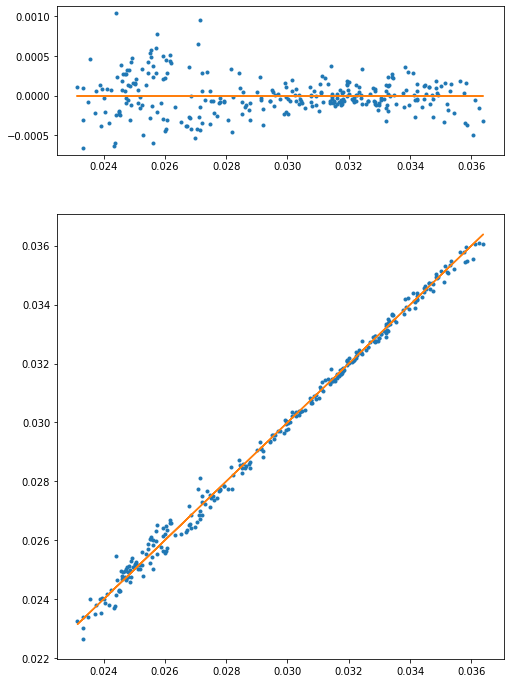

In [41]:
x_train, y_train = dm[:700][NEW_FTR_VOLS].values, xx[:700]
x_test, y_test   = dm[700:][NEW_FTR_VOLS].values, xx[700:]

n = nn_test(x_train, y_train, x_test, y_test, device='cuda:3', 
            sz_hiddens=[12, 17, 20, 17, 12], max_epoch=2000)

使用神经网络生成新的C物质输出

In [42]:
nxx = n.predict(dm[NEW_FTR_VOLS])

线性模型拟合神经网络输出

mse: 3.7898021510357133e-07 
mape 0.016800239468324877 
r2: 0.9714250564238603 
cor: 0.9873590511082221 
pre: 0.9995487669910955


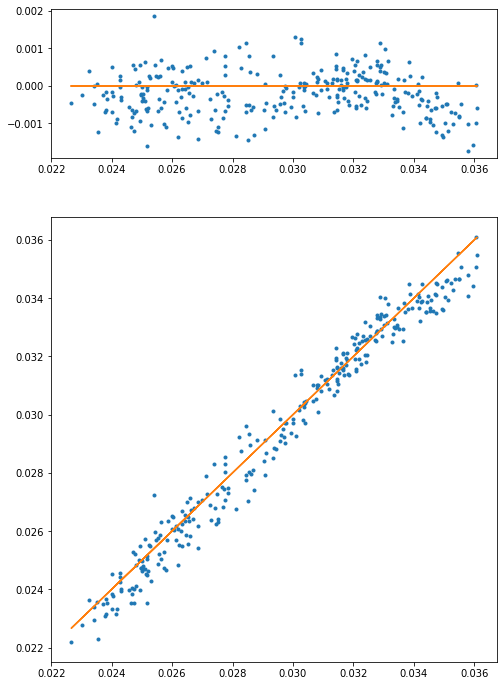

In [43]:
x_train, y_train = dm[:700][NEW_FTR_VOLS].values, nxx[:700]
x_test, y_test = dm[700:][NEW_FTR_VOLS].values, nxx[700:]

l = lr_test(x_train, y_train, x_test, y_test)

扩大神经网络输出与线性模型的差异

In [44]:
nxxx = maker.normalized_trans2(nxx, l.predict(dm[NEW_FTR_VOLS]), 
                               maker.amplify_diff)

比较新输出与原始数据的差异，MAPE不要超过0.1

mse: 4.61835478823595e-06 
mape 0.06203362837678969 
r2: 0.6827854784877376 
cor: 0.8605289121825799 
pre: 0.9943607303464815


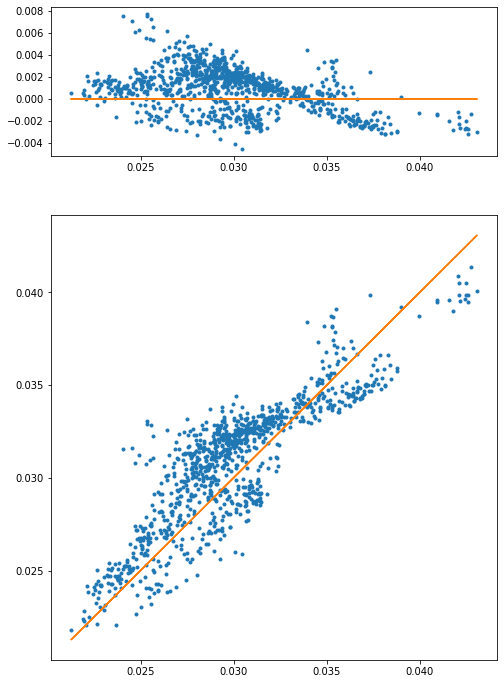

In [45]:
evaluate(nxxx, dm.OutRateC)

测试神经网络对新C输出数据的效果

mse: 4.2468743095675486e-07 
mape 0.017012418651799692 
r2: 0.9719492911035351 
cor: 0.9864387360230539 
pre: 0.9994935124938036


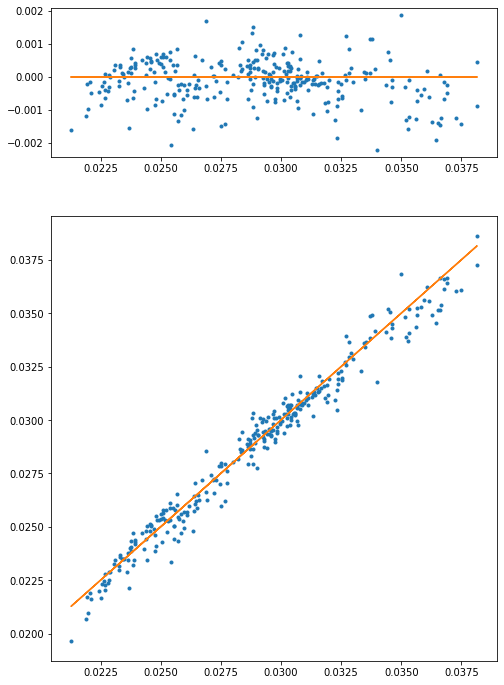

In [46]:
x_train, y_train = dm[:700][NEW_FTR_VOLS].values, nxxx[:700]
x_test, y_test = dm[700:][NEW_FTR_VOLS].values, nxxx[700:]

n = nn_test(x_train, y_train, x_test, y_test,
            device='cuda:3', sz_hiddens=[12, 17, 21, 17, 12], max_epoch=2000)

比较线性模型的拟合效果

mse: 4.024307436360862e-06 
mape 0.053954262745040844 
r2: 0.7341935075570144 
cor: 0.8726167499913696 
pre: 0.9953825737042035


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

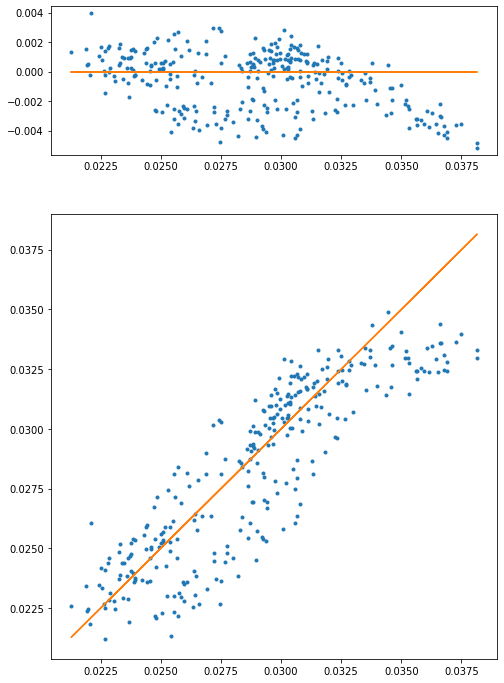

In [47]:
x_train, y_train = dm[:700][NEW_FTR_VOLS].values, nxxx[:700]
x_test, y_test = dm[700:][NEW_FTR_VOLS].values, nxxx[700:]

lr_test(x_train, y_train, x_test, y_test)

观察新的C数据与原始数据、线性模型、神经网络拟合结果在时间上的差异

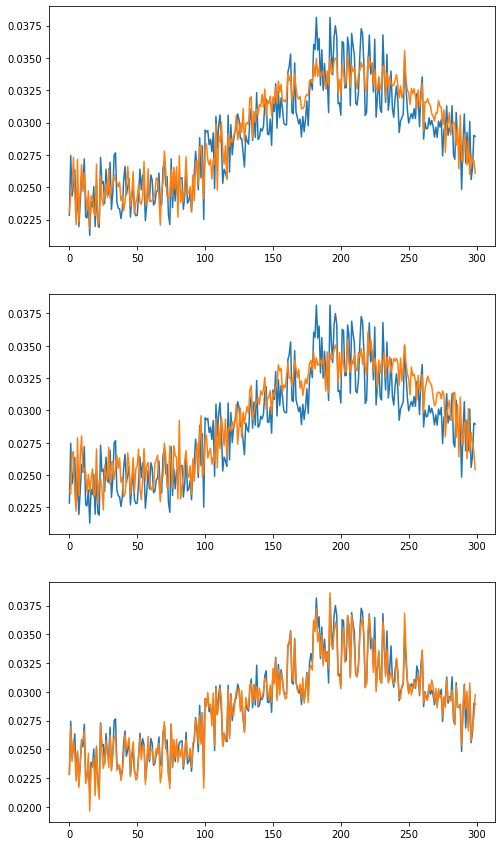

In [49]:
plt.subplots(figsize=(8,15))

plt.subplot(311)
plt.plot(nxxx[700:])
plt.plot(dm[700:].OutRateC.values)

plt.subplot(312)
plt.plot(nxxx[700:])
plt.plot(l.predict(dm[700:][NEW_FTR_VOLS]))

plt.subplot(313)
plt.plot(nxxx[700:])
plt.plot(n.predict(dm[700:][NEW_FTR_VOLS]))

把扩大差异后的神经网络拟合结果保存新的OutRateC

In [50]:
dm['OutRateC_n'] = nxxx

将其它物质输出率进行非线性化、并加上噪声抖动

In [51]:
dm['OutRateA_n'] = maker.normalized_trans(dm.OutRateA.values, 
                             maker.nonlinearize,
                             kl = [0.8, 0.25, -0.1, 0.05])

dm['OutRateB_n'] = maker.normalized_trans(dm.OutRateB.values, 
                             maker.nonlinearize,
                             kl = [1.02, -0.15, 0.05, 0.1])

dm['OutRateD_n'] = maker.normalized_trans(dm.OutRateD.values, 
                             maker.nonlinearize,
                             kl = [0.95, -0.1, 0.05, 0.1])

In [52]:
dm['OutRateA_n']  = maker.add_nois(dm['OutRateA_n'])
dm['OutRateB_n']  = maker.add_nois(dm['OutRateB_n'])
dm['OutRateD_n']  = maker.add_nois(dm['OutRateD_n'])

In [53]:
dm['OutRateE_n'] = 1 - dm.OutRateA_n - dm.OutRateB_n - dm.OutRateC_n - dm.OutRateD_n

将输出率折算成输出质量

In [56]:
mass_in = dm.InMassA + dm.InMassB

根据速度累积变化输出质量

In [62]:
mass_out = np.array(list(maker.conditional_acc(mass_in.values, 
                                               condition=dm.OutSpeed.values, 
                                               decay_rate=0.1)))

In [65]:
quintile((mass_in - mass_out) / mass_in)

array([-0.03635177, -0.00725613,  0.00012259,  0.00798845,  0.04179803])

将输出率折算成质量，并存入数据集

In [66]:
dm['OutMassA'] = mass_out * dm.OutRateA_n
dm['OutMassB'] = mass_out * dm.OutRateB_n
dm['OutMassC'] = mass_out * dm.OutRateC_n
dm['OutMassD'] = mass_out * dm.OutRateD_n
dm['OutMassE'] = mass_out * dm.OutRateE_n

In [177]:
# dm['OutMassA'] = mass_in * dm.OutRateA_n
# dm['OutMassB'] = mass_in * dm.OutRateB_n
# dm['OutMassC'] = mass_in * dm.OutRateC_n
# dm['OutMassD'] = mass_in * dm.OutRateD_n
# dm['OutMassE'] = mass_in * dm.OutRateE_n

折算新的速度

In [75]:
speed_out = mass_out / mass_in * dm.InSpeed

In [80]:
out_diff_rate = (speed_out / dm.OutSpeed).mean()

In [81]:
dm['OutSpeed_n'] = speed_out / out_diff_rate

mse: 8.39359347284121e-06 
mape 0.01732384694763732 
r2: 0.9621822411349665 
cor: 0.9815851808034062 
pre: 0.9990654989695819


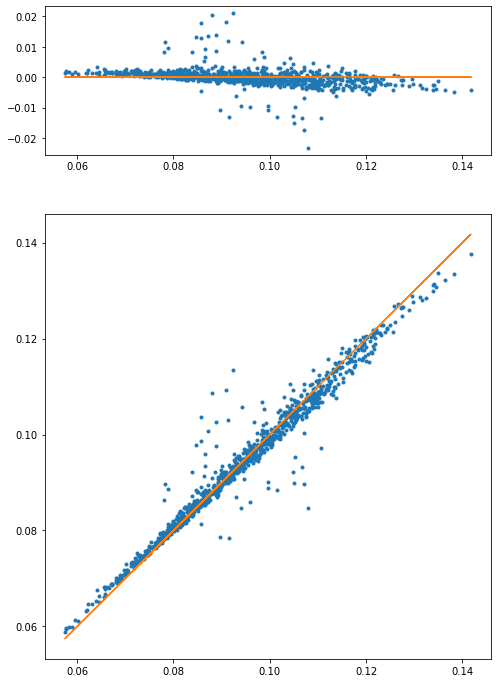

In [82]:
evaluate(dm.OutSpeed_n, dm.OutSpeed)

检测用新特征预测新质量输出的效果

In [69]:
x_train, y_train = dm[:700][NEW_FTR_VOLS].values, dm[:700]['OutMassC'].values
x_test, y_test = dm[700:][NEW_FTR_VOLS].values, dm[700:]['OutMassC'].values

mse: 4.2192554466695353e-07 
mape 0.027694001996355386 
r2: 0.9201486867303789 
cor: 0.9661934199645735 
pre: 0.9986611559991843


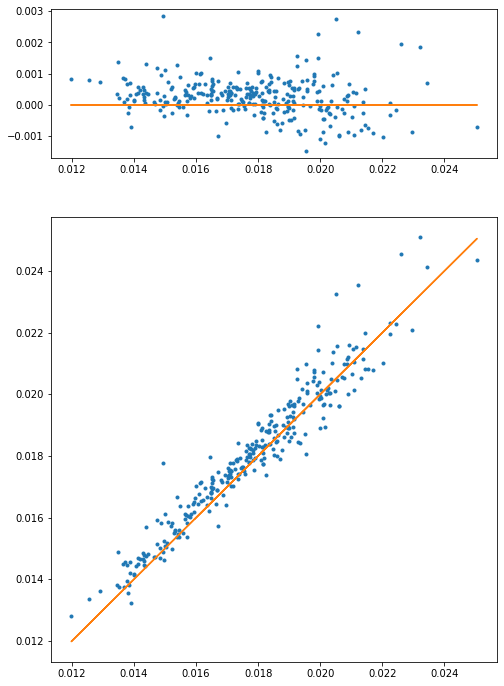

In [72]:
n = nn_test(x_train, y_train, x_test, y_test,
            device='cuda:3', sz_hiddens=[12, 17, 21, 17, 12], max_epoch=2000)

mse: 1.4392607720276865e-06 
mape 0.053300444323924154 
r2: 0.7276134042214085 
cor: 0.862848535052745 
pre: 0.9958034798841147


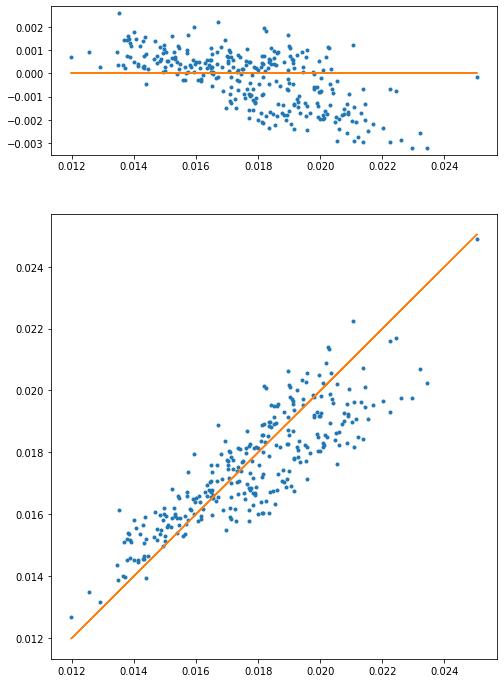

In [70]:
l = lr_test(x_train, y_train, x_test, y_test)

保存生成的数据

In [83]:
FILE_SAVE = 'data/ok_mock_data_20191010_1'
dm.to_csv(FILE_SAVE, index=False)